In [1]:
import os

# to avoid the following error when using MPS (GPU in ARM architecture)):
# NotImplementedError: The operator 'aten::scatter_reduce.two_out'
# is not currently implemented for the MPS device. If you want
# this op to be added in priority during the prototype phase of
# this feature, please comment on
# https://github.com/pytorch/pytorch/issues/77764.
# As a temporary fix, you can set the environment variable
# `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as
# a fallback for this op.
# WARNING: this will be slower than running natively on MPS.
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # before importing torch


\# TODO

- BatchNormalization?
- ハイパーパラメータチューニング (optuna?)
- モデルの解釈 (tanhやpoolingについて)
- dropoutの導入？←過学習対策
- autumentation?
- モデルの途中保存 (エポック毎?)

In [2]:
import pandas as pd
import rdkit
from rdkit import Chem
from sklearn.model_selection import train_test_split

import torch
import torch_geometric
import torch_geometric.nn
import torch_geometric.data
import torch_geometric.loader

from src.data import GraphDataset
from src.model import GCN
from src.torch_utils import fit, eval_loss, evaluate_history, torch_seed


In [3]:
torch.__version__


'2.1.0'

In [4]:
torch_geometric.__version__


'2.4.0'

In [5]:
rdkit.__version__


'2023.09.1'

In [6]:
seed = 334
batch_size = 256

torch_seed(seed)


In [7]:
df_raw = pd.read_csv("./data/curated-solubility-dataset.csv", index_col=0)
# 計算時間短縮
# df_raw = df_raw.iloc[:1000]
print(df_raw.shape)
df_raw.head()


(9982, 25)


,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,MolLogP,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
ID,,,,,,,,,,,,,,,,,,,,,
A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,3.9581,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,2.4055,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,2.1525,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,8.1161,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,2.4854,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [8]:
smiles = df_raw["SMILES"]
y = df_raw["Solubility"]


In [9]:
# scaling
y_mean = y.mean()
y_std = y.std(ddof=1)


In [10]:
smiles = smiles.tolist()
y = ((y - y_mean) / y_std).tolist()


In [11]:
mols = map(Chem.MolFromSmiles, smiles)


In [12]:
dataset = GraphDataset(mols, y, n_jobs=-1)
dataset


[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not removing hydrogen atom without neighbors
[07:17:16] WARNING: not r

GraphDataset(9982)

In [13]:
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = torch_geometric.loader.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)
# the following is deprecated
# dataloader = torch_geometric.data.DataLoader(
#     dataset, batch_size=batch_size, shuffle=True
# )
dataloader


In [14]:
dataset_train, dataset_test = train_test_split(
    dataset, test_size=0.2, random_state=seed
)
print(len(dataset_train), len(dataset_test))


7985 1997


In [15]:
dataloader_train = torch_geometric.loader.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True
)
dataloader_test = torch_geometric.loader.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False
)


In [16]:
model = GCN(in_channels=dataset_train[0].x.shape[1], embedding_size=64)
print(model)


GCN(
  (initial_conv): GCNConv(30, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


In [17]:
data = dataset_train[0]


In [18]:
# Need 'tabulate' package
print(torch_geometric.nn.summary(model, data))


+-------------------------+---------------+----------------+----------+
| Layer                   | Input Shape   | Output Shape   | #Param   |
|-------------------------+---------------+----------------+----------|
| GCN                     | [11, 11]      | [1]            | 14,593   |
| ├─(initial_conv)GCNConv |               | [11, 64]       | 1,984    |
| ├─(conv1)GCNConv        |               | [11, 64]       | 4,160    |
| ├─(conv2)GCNConv        |               | [11, 64]       | 4,160    |
| ├─(conv3)GCNConv        |               | [11, 64]       | 4,160    |
| ├─(out)Linear           | [1, 128]      | [1, 1]         | 129      |
+-------------------------+---------------+----------------+----------+


In [19]:
model(data)


tensor([-0.1715], grad_fn=<ViewBackward0>)

In [20]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [21]:
history = fit(
    model.to(device),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=torch.nn.MSELoss(),
    train_loader=dataloader_train,
    test_loader=dataloader_test,
    num_epochs=10,
    # num_epochs=100,
    device=device,
    ipynb=True,
)


  0%|          | 0/32 [00:00<?, ?it/s]

/Users/yu9824/miniforge3/envs/torch39/lib/python3.9/site-packages/torch_geometric/utils/scatter.py:94: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391825142/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(


Epoch [1/10], loss: 0.80411 val_loss: 0.72426, 


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.61204 val_loss: 0.60290, 


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.53517 val_loss: 0.54612, 


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.49333 val_loss: 0.53875, 


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.48017 val_loss: 0.48904, 


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.44538 val_loss: 0.45540, 


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.41694 val_loss: 0.43769, 


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.40490 val_loss: 0.42461, 


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.38394 val_loss: 0.41872, 


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.37296 val_loss: 0.41696, 


初期状態: 損失: 0.72426
最終状態: 損失: 0.41696


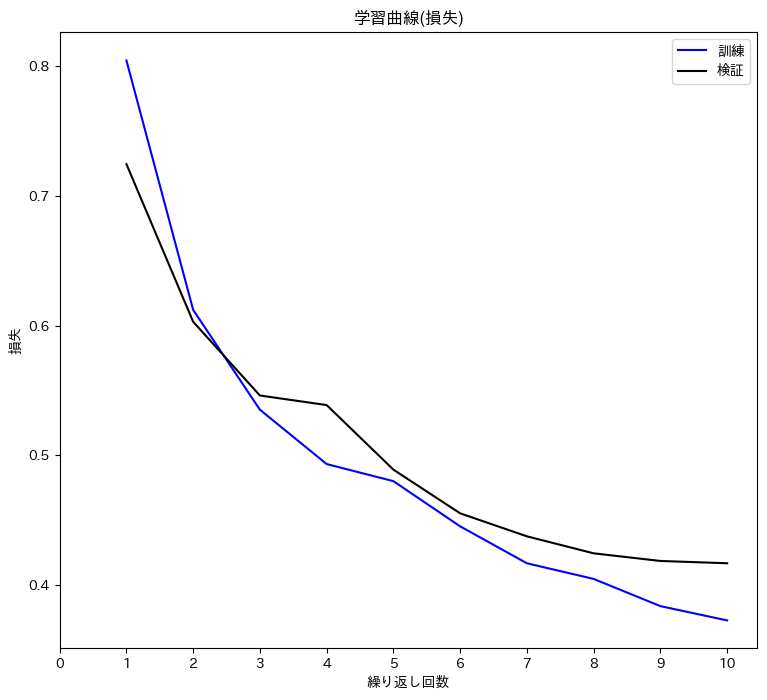

In [22]:
evaluate_history(history)
